## Project Description:
Build a machine learning model prototype to be able to forecast the churn of clients for a telecom operator using the dataset provided. The data consists of files obtained from different sources:
- contract.csv — contract information
- personal.csv — the client's personal data
- internet.csv — information about Internet services
- phone.csv — information about telephone services

The target feature for this project is the 'EndDate' column equals 'No'. The primary metric for qualification is AUC-ROC with the minimum requirement of AUC-ROC > 0.75

Make a report at the end and answer the following questions:

- What steps of the plan were performed and what steps were skipped (explain why)?
- What difficulties did you encounter and how did you manage to solve them?
- What were some of the key steps to solving the task?
- What is your final model and what quality score does it have?

###  Project - Work Plan

In [142]:
# Import all the packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

### Step 1: Inspect and Clean Data

In [143]:
# Read all the datafiles
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [144]:
# Look at contract dataset using info method
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [145]:
# Convert column names to snake case
contract.columns = (contract.columns.str.strip().str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True).str.lower())
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [146]:
contract["total_charges"] = pd.to_numeric(contract["total_charges"], errors="coerce")
#contract["begin_date"] = pd.to_datetime(contract["begin_date"], errors="coerce")
#contract["end_date"]   = pd.to_datetime(contract["end_date"], errors="coerce")
contract.dtypes

customer_id           object
begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
dtype: object

In [147]:
# Check for Null Values and Duplicates
print(f"contract null values: \n{contract.isnull().sum()}")
print(f"\ncontract Duplicate Values: {contract.duplicated().sum()}")

contract null values: 
customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
dtype: int64

contract Duplicate Values: 0


In [148]:
contract[contract['total_charges'].isnull()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [149]:
# Drop the Null Values because its a very small number
contract = contract.dropna()
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


In [150]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [151]:
# Repeat with personal dataset

In [152]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [153]:
personal.columns = (personal.columns.str.strip().str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True).str.lower())
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [154]:
print(f"personal null values: \n{personal.isnull().sum()}")
print(f"\npersonal Duplicate Values: {personal.duplicated().sum()}")

personal null values: 
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

personal Duplicate Values: 0


In [155]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [156]:
# Repeat with internet dataset

In [157]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [158]:
internet.columns = (internet.columns.str.strip().str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True).str.lower())
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [159]:
print(f"internet null values: \n{internet.isnull().sum()}")
print(f"\ninternet Duplicate Values: {internet.duplicated().sum()}")

internet null values: 
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

internet Duplicate Values: 0


In [160]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [161]:
# Finally repeat with the phone dataset

In [162]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [163]:
phone.columns = (phone.columns.str.strip().str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True).str.lower())
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [164]:
print(f"phone null values: \n{phone.isnull().sum()}")
print(f"\nphone Duplicate Values: {phone.duplicated().sum()}")

phone null values: 
customer_id       0
multiple_lines    0
dtype: int64

phone Duplicate Values: 0


In [165]:
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Step 2: Merge the 4 datasets into 1 Master dataset

In [166]:
# First merge contract and personal datasets
full = contract.merge(personal, on="customer_id", how="left")

# Then merge the internet dataset
full = full.merge(internet, on="customer_id", how="left")

# Finally merge the phone dataset
full = full.merge(phone, on="customer_id", how="left")

print(full.shape)
full.head(3)

(7032, 20)


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [167]:
# Check the merged dataset for duplicates and missing values
print(full.isnull().sum())
print(f"\nDuplicates in the Merged Set: {full.duplicated().sum()}")

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
multiple_lines        680
dtype: int64

Duplicates in the Merged Set: 0


In [168]:
######
full['streaming_movies'].unique()

array(['No', 'Yes', nan], dtype=object)

In [169]:
# Address the null values
full = full.fillna("No")
print(full.isnull().sum())
print(f"\nDuplicates in the Merged Set: {full.duplicated().sum()}")

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Duplicates in the Merged Set: 0


### Step 3: Convert Categorical Data

In [170]:
full.nunique()

customer_id          7032
begin_date             76
end_date                5
type                    3
paperless_billing       2
payment_method          4
monthly_charges      1584
total_charges        6530
gender                  2
senior_citizen          2
partner                 2
dependents              2
internet_service        3
online_security         2
online_backup           2
device_protection       2
tech_support            2
streaming_tv            2
streaming_movies        2
multiple_lines          2
dtype: int64

In [171]:
# First check which columns are binary within the dataset
binary_cols = [col for col in full if full[col].nunique() == 2]
print(binary_cols)

['paperless_billing', 'gender', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


In [172]:
# Now convert binary categorical columns to numeric
full[binary_cols] = full[binary_cols].replace({
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0})

In [173]:
# Check for numeric columns
print(full.select_dtypes(include=['number']).columns)

Index(['paperless_billing', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines'],
      dtype='object')


In [174]:
full.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0,0,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,1,0,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1,0,0,0,DSL,1,1,0,0,0,0,0


### Step 4: Analyze Distributions and Relationships

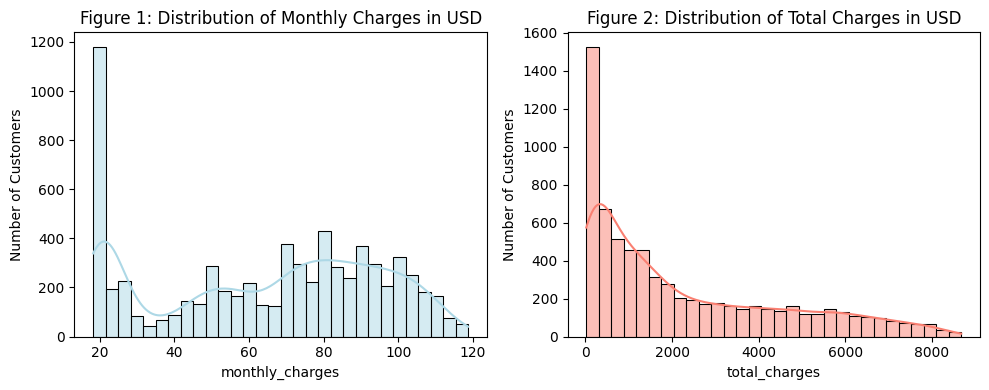

In [175]:
# Let's look at the distributions of both Monthly Charges and Total Charges
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(full["monthly_charges"], bins=30, ax=axes[0], kde=True, color='lightblue')
sns.histplot(full["total_charges"], bins=30, ax=axes[1], kde=True, color='salmon')
axes[0].set_title("Figure 1: Distribution of Monthly Charges in USD")
axes[0].set_ylabel("Number of Customers")
axes[1].set_title("Figure 2: Distribution of Total Charges in USD")
axes[1].set_ylabel("Number of Customers")
plt.tight_layout()
plt.show()

In [176]:
# Check the correlation matrix of all the features
corr_matrix = full.corr()
corr_matrix

,paperless_billing,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
paperless_billing,1.000000,0.351930,0.157830,-0.011902,0.156258,-0.013957,-0.110131,-0.004051,0.127056,0.104079,0.037536,0.224241,0.211583,0.163746
monthly_charges,0.351930,1.000000,0.651065,-0.013779,0.219874,0.097825,-0.112343,0.296447,0.441529,0.482607,0.338301,0.629668,0.627235,0.490912
total_charges,0.157830,0.651065,1.000000,0.000048,0.102411,0.319072,0.064653,0.412619,0.510100,0.522881,0.432868,0.515709,0.519867,0.469042
gender,-0.011902,-0.013779,0.000048,1.000000,-0.001819,-0.001379,0.010349,-0.016328,-0.013093,-0.000807,-0.008507,-0.007124,-0.010105,-0.008883
senior_citizen,0.156258,0.219874,0.102411,-0.001819,1.000000,0.016957,-0.210550,-0.038576,0.066663,0.059514,-0.060577,0.105445,0.119842,0.142996
partner,-0.013957,0.097825,0.319072,-0.001379,0.016957,1.000000,0.452269,0.143346,0.141849,0.153556,0.120206,0.124483,0.118108,0.142561
dependents,-0.110131,-0.112343,0.064653,0.010349,-0.210550,0.452269,1.000000,0.080786,0.023639,0.013900,0.063053,-0.016499,-0.038375,-0.024307
online_security,-0.004051,0.296447,0.412619,-0.016328,-0.038576,0.143346,0.080786,1.000000,0.283285,0.274875,0.354458,0.175514,0.187426,0.098592
online_backup,0.127056,0.441529,0.510100,-0.013093,0.066663,0.141849,0.023639,0.283285,1.000000,0.303058,0.293705,0.281601,0.274523,0.202228
device_protection,0.104079,0.482607,0.522881,-0.000807,0.059514,0.153556,0.013900,0.274875,0.303058,1.000000,0.332850,0.389924,0.402309,0.201733


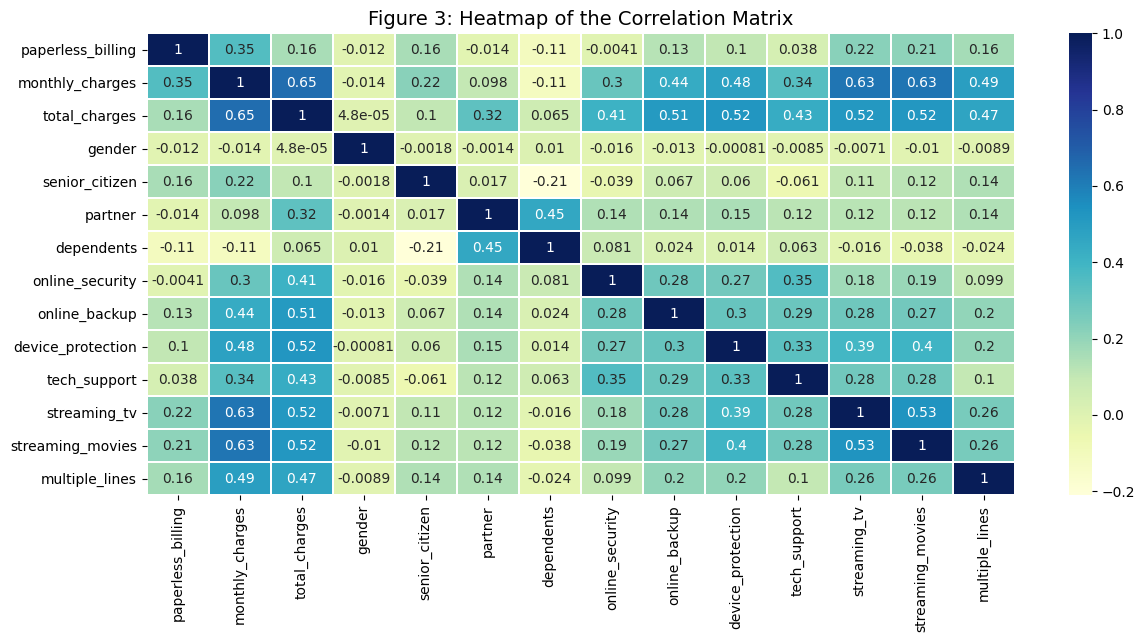

In [177]:
# Use a Heatmap
plt.figure(figsize = (14,6))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Figure 3: Heatmap of the Correlation Matrix", fontsize=14)
plt.show()

Text(0.5, 0.98, 'Figure 4: Key features related to Monthly Charges')

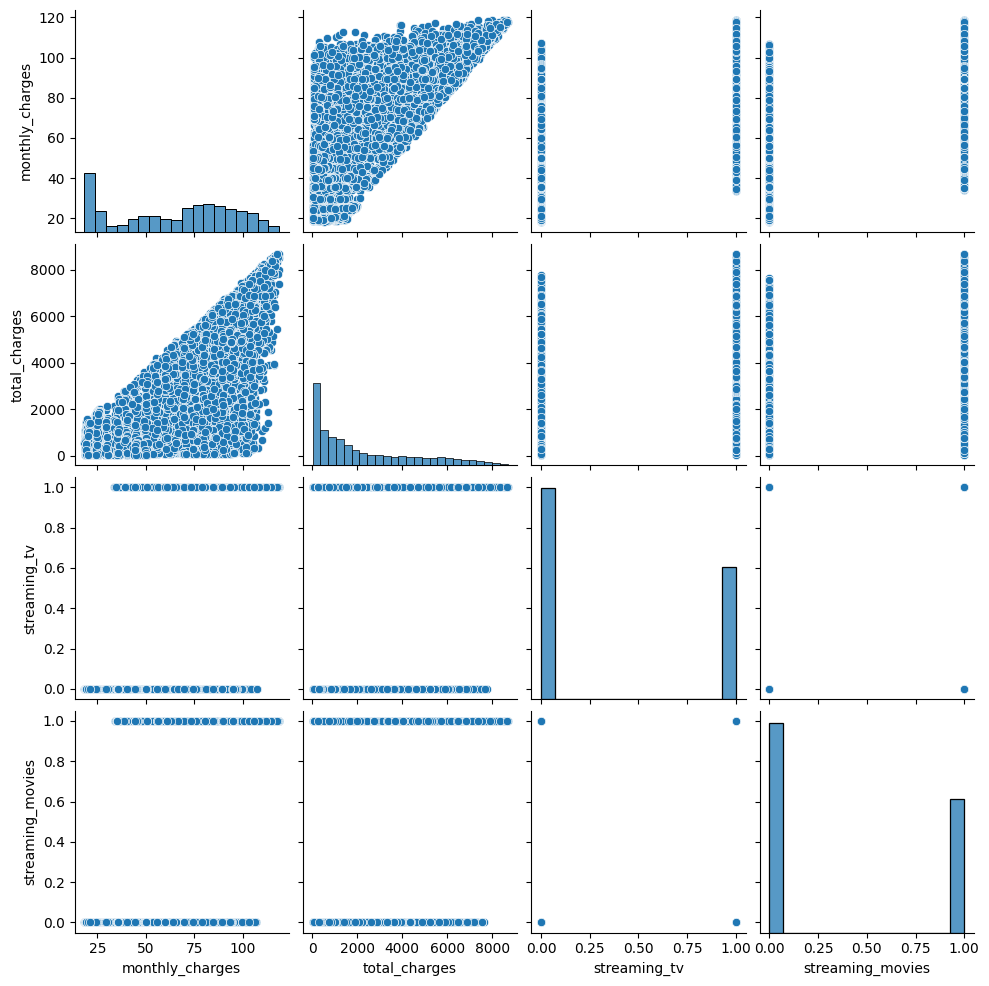

In [178]:
# Let's check moderate relationships with monthly charges
monthly_relations = corr_matrix['monthly_charges'][abs(corr_matrix['monthly_charges']) >= 0.5].index.tolist()
sns.pairplot(full[monthly_relations])
fig.suptitle("Figure 4: Key features related to Monthly Charges")

Text(0.5, 0.98, 'Figure 5: Key features related to total charges')

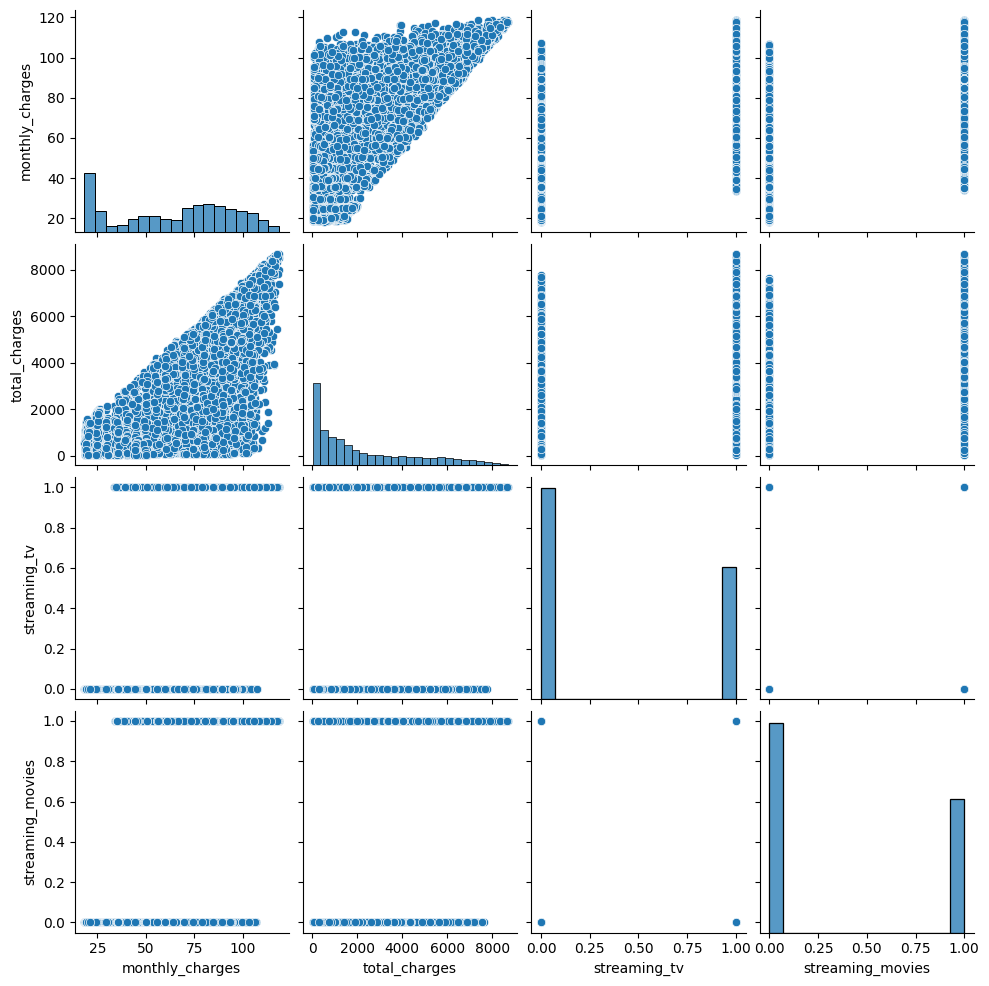

In [179]:
# Let's check moderate relationships with total charges
total_relations = corr_matrix['total_charges'][abs(corr_matrix['monthly_charges']) >= 0.5].index.tolist()
sns.pairplot(full[total_relations])
fig.suptitle("Figure 5: Key features related to total charges")

### Step 5: Identify any other relationships

In [180]:
full.head(2)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0,0,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,1,0,0,0,DSL,1,0,1,0,0,0,0


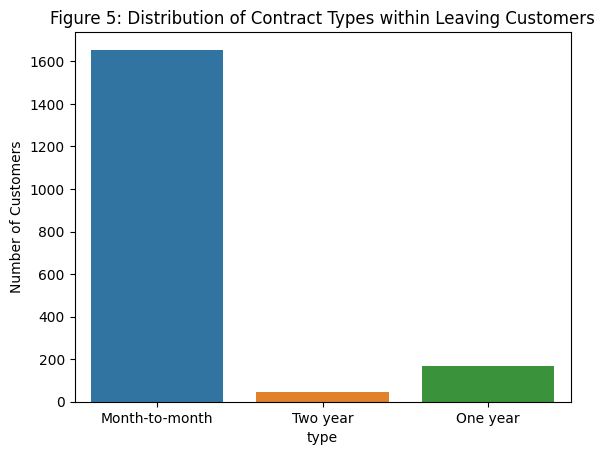

In [181]:
# Let's look into customers with End Date and their contact types
customers_leaving = full[full['end_date']!='No']
sns.countplot(x="type", data=customers_leaving)
plt.title("Figure 5: Distribution of Contract Types within Leaving Customers")
plt.ylabel("Number of Customers")
plt.show()

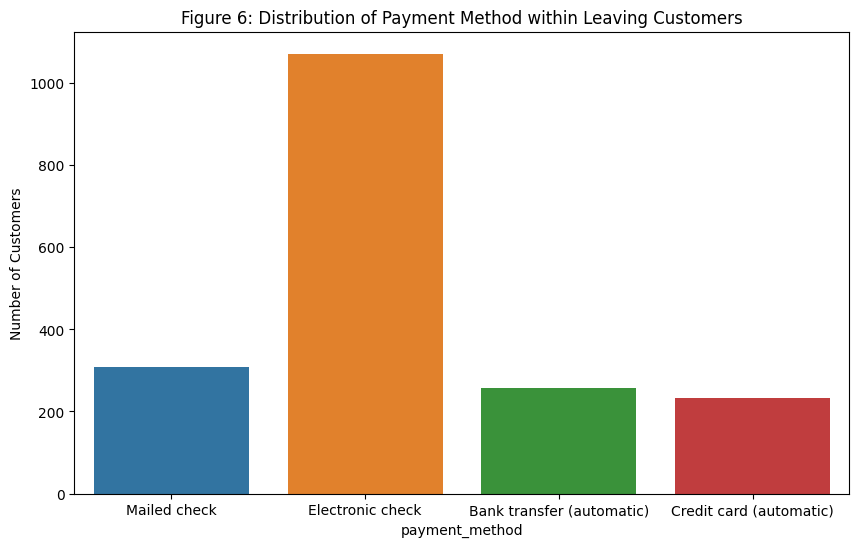

In [182]:
plt.figure(figsize=(10,6)) 
sns.countplot(x="payment_method", data=customers_leaving)
plt.title("Figure 6: Distribution of Payment Method within Leaving Customers")
plt.ylabel("Number of Customers")
plt.show()

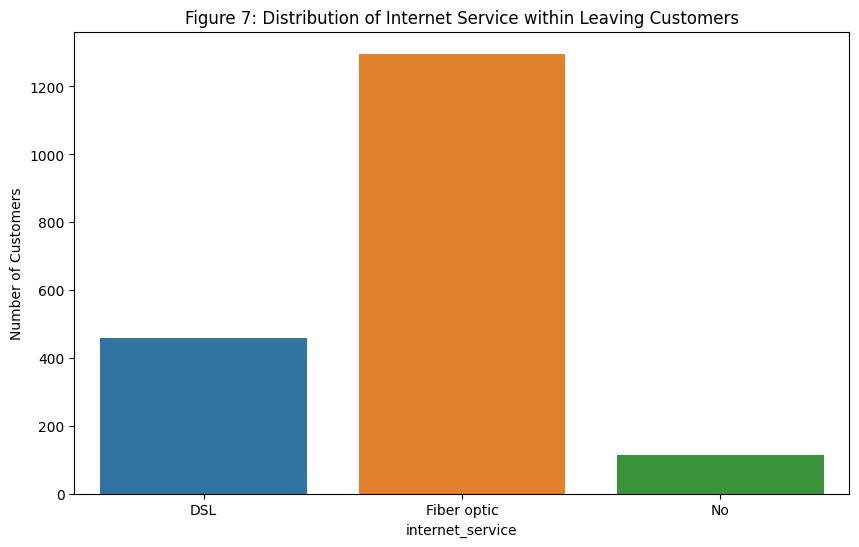

In [183]:
plt.figure(figsize=(10,6)) 
sns.countplot(x="internet_service", data=customers_leaving)
plt.title("Figure 7: Distribution of Internet Service within Leaving Customers")
plt.ylabel("Number of Customers")
plt.show()

In [184]:
full.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0,0,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,1,0,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1,0,0,0,DSL,1,1,0,0,0,0,0


In [185]:
# Let's define the target and features
target = (full['end_date'] == 'No').astype('int')
features = full.drop(columns=['end_date', 'begin_date', 'customer_id'])
print(target.shape, features.shape)

(7032,) (7032, 17)


In [186]:
# Split the dataset into training, test and validation sets

features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size = 0.25, random_state = 123, stratify = target)

features_val, features_test, target_val, target_test = train_test_split(
    features_temp, target_temp, test_size = 0.5, random_state = 123, stratify = target_temp)

print(features_train.shape, features_test.shape, features_val.shape)

(5274, 17) (879, 17) (879, 17)


In [187]:
# let's do a check to see that startify worked
print(target_train.value_counts(normalize='True'))
print(target_test.value_counts(normalize='True'))
print(target_val.value_counts(normalize='True'))

1    0.734168
0    0.265832
Name: end_date, dtype: float64
1    0.733788
0    0.266212
Name: end_date, dtype: float64
1    0.734926
0    0.265074
Name: end_date, dtype: float64


In [188]:
# Let's identify the numerical and categorical features
numeric_cols = features.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = features.select_dtypes(include=['object']).columns.tolist()

In [189]:
# Apply a Scaler to the Numeric Features
scaler = StandardScaler()
features_train_num = pd.DataFrame(scaler.fit_transform(features_train[numeric_cols]), columns = numeric_cols, index = features_train.index)
features_val_num = pd.DataFrame(scaler.transform(features_val[numeric_cols]), columns = numeric_cols, index = features_val.index)
features_test_num = pd.DataFrame(scaler.transform(features_test[numeric_cols]), columns = numeric_cols, index = features_test.index)

In [190]:
# Feature Encode with OneHotEncoder or Categorical features
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
features_train_cat = pd.DataFrame(ohe.fit_transform(features_train[cat_cols]), columns = ohe.get_feature_names(cat_cols), index = features_train.index)
features_val_cat = pd.DataFrame(ohe.transform(features_val[cat_cols]), columns = ohe.get_feature_names(cat_cols), index = features_val.index)
features_test_cat = pd.DataFrame(ohe.transform(features_test[cat_cols]), columns = ohe.get_feature_names(cat_cols), index = features_test.index)

In [191]:
# Combine all numeric and categorical features into one features_final 
features_train_final = pd.concat([features_train_num, features_train_cat], axis=1)
features_val_final = pd.concat([features_val_num, features_val_cat], axis=1)
features_test_final = pd.concat([features_test_num, features_test_cat], axis=1)

In [192]:
# Start with a Dummy model
dummy_model = DummyClassifier(strategy='most_frequent', random_state=123)
dummy_model.fit(features_train_final, target_train)
dummy_pred = dummy_model.predict_proba(features_val_final)[:, 1]
dummy_auc = roc_auc_score(target_val, dummy_pred)
print("Dummy Classifier AUC-ROC:", dummy_auc)

Dummy Classifier AUC-ROC: 0.5


In [193]:
# Baseline Random Forest model
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(features_train_final, target_train)

rf_pred_proba = rf_model.predict_proba(features_val_final)[:,1]
rf_baseline_auc = roc_auc_score(target_val, rf_pred_proba)

print("Baseline Random Forest AUC-ROC:", rf_baseline_auc.round(3))

Baseline Random Forest AUC-ROC: 0.832


In [194]:
# Fine Tune Random Forest model
param_grid = {"n_estimators": [50, 100, 200], "max_depth": [5, 10, 15], 
              "min_samples_split": [2, 5, 10],"min_samples_leaf": [1, 2, 4]}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=123), 
                           param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1, verbose=1)

grid_search.fit(features_train_final, target_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [195]:
# Random Forest model using best parameters
best_rf_model = grid_search.best_estimator_
best_rf_pred_proba = best_rf_model.predict_proba(features_val_final)[:,1]

best_rf_model_auc = roc_auc_score(target_val, best_rf_pred_proba)
print("Random Forest Best Model AUC-ROC:", best_rf_model_auc.round(3))

Random Forest Best Model AUC-ROC: 0.856


In [196]:
# Baseline with Logistic Regression Model
logr_model = LogisticRegression(random_state=123)
logr_model.fit(features_train_final, target_train)

logr_pred_proba = logr_model.predict_proba(features_val_final)[:, 1]
logr_baseline_auc = roc_auc_score(target_val, logr_pred_proba)

print("Baseline Logistic Regression AUC-ROC:", logr_baseline_auc.round(3))

Baseline Logistic Regression AUC-ROC: 0.846


In [197]:
# Fine Tune Logistic Regression Model
param_grid = {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2"], "solver": ["liblinear", "saga"]}

grid_search = GridSearchCV(estimator= LogisticRegression(max_iter=5000, random_state=123), 
                           param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1, verbose=1)

grid_search.fit(features_train_final, target_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [198]:
# Logistic Regression model using the best parameters
best_logr_model = grid_search.best_estimator_

best_logr_pred_proba = best_logr_model.predict_proba(features_val_final)[:, 1]
best_logr_auc = roc_auc_score(target_val, best_logr_pred_proba)

print("Best Logistic Regression Model AUC-ROC:", best_logr_auc.round(3))

Best Logistic Regression Model AUC-ROC: 0.846


In [199]:
# Baseline LightGBM Model
lgb_model = lgb.LGBMClassifier(random_state=123)
lgb_model.fit(features_train_final, target_train)

lgb_proba_pred = lgb_model.predict_proba(features_val_final)[:, 1]
lgb_baseline_auc = roc_auc_score(target_val, lgb_proba_pred)

print("Baseline LightGBM Model AUC-ROC:", lgb_baseline_auc.round(3))

Baseline LightGBM Model AUC-ROC: 0.851


In [200]:
# Fine Tune Light GBM model
param_grid = {'num_leaves': [15, 25, 50], 'max_depth': [5, 10, 15], 'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [100, 200, 300]}

grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=123),
                           param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

grid_search.fit(features_train_final, target_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 15}


In [201]:
# LightGBM model using the best parameters
best_lgb_model = grid_search.best_estimator_
best_lgb_proba_pred = best_lgb_model.predict_proba(features_val_final)[:, 1]

best_lgb_auc = roc_auc_score(target_val, best_lgb_proba_pred)
print("Best LightGBM model AUC-ROC:", best_lgb_auc.round(3))

Best LightGBM model AUC-ROC: 0.854


In [202]:
# Predict on test set using the best model - Random Forest
best_rf_pred_proba = best_rf_model.predict_proba(features_test_final)[:,1]
best_rf_model_auc_test = roc_auc_score(target_test, best_rf_pred_proba)
print("Random Forest Best Model AUC-ROC on Test Set:", best_rf_model_auc_test.round(3))

Random Forest Best Model AUC-ROC on Test Set: 0.855


<conclusion>

## Conclusion:

<div><span style= color:blue> 
After the EDA, the next step was to build multiple models, train and validate them and then hypertune the parameters (fine-tune) to yield a AUC-ROC metric. The goal was to compare all AUC-ROC score generated from all the models and choose the model with the highest score. This model would ideally be the best to use for the telecom operator in order to help them forecast their churn clients. As such, I started with a dummy model just to see how random guessing would fare with the dataset, and I got a AUC-ROC of 0.5, which is very low but it sets the stage for model building. Next, I built 3 classifier models of Random Forest, Logistic Regression and LightGBM. After training all three on 75% training dataset, I applied GridSearchCV to find the best parameters for fine tuning each model to yield the highest AUC-ROC metric. Granted, each of the models yielded an effectively very similar score of between 0.84 - 0.86. The differences arrive when comparing was quite minor. Nonetheless, in comparing all the fine-tuned models, I got the best AUC-ROC score from the Random Forest model of 0.86. Then I tested the this Random Forest model on the testing dataset and still got a AUC-ROC score of 0.86. I attempted many different tactics of feature engineering and hypertuning parameters but could not increase the score above the 0.86 mark. As such, I will submit with this and hope to learn how to improve my model building skills and practices.
</div>

## Project Report

<b>What steps of the plan were performed and what steps were skipped (explain why)?

The Work Plan developed in the first part of this project was as listed in Steps 1 - 5 below:
- Step 1: Inspect the data and perform data cleaning
- Step 2: Merge Datasets into 1 Master set
- Step 3: Convert categorical data to numeric
- Step 4: Look at Distributions and Relationships
- Step 5: Identify any other relationships

Each step was indeed performed as seen in the solution code and none of them were skipped because the work plan was designed with the intention of executing a code that would fullfill all the requirements of the project. The reason each step was performed is because each step helps to develop the project from just some meangingless seperate data into a coherent and integrated working model that takes into account all the relationships within the datasets. Each step is very important and cannot be skipped since it would either skew the data or hinder the model from behaving at its best. That being said, additional steps were added into the Solution Code since the Work Plan does not include any steps for actually building, training, validating and testing the models. As such these steps would be something like the following:

- Step 6: Define Target and Features and apply Feature Engineering
- Step 7: Build and Train multiple models and hypertune the parameters
- Step 8: Choose the model with the greatest AUC-ROC score and test it on the testing dataset

<b> What difficulties did you encounter and how did you manage to solve them?

There were many challenges that occured during the course of this project and each of them was handled differently in order to resolve and move forward. The first major challenge that was faced was how to combine the data from the 4 files into 1 coherent dataset for the model to use. This was resolved by understanding the different types of joins such as inner, outer, left and right. The winner was left join in the interest of saving as much data as possible since a different joing could omit data not found in both datasets. This did pose a new smaller challenge of addressing null values once the datasets were fully merged into 1. It was really helpful that all 4 datasets shared the same column in 'customer-id', as such they could all be merged easily, otherwise there would've been a bigger challenge of curating new columns to merge the datasets.

The next challenges were all posed during the model building stages since that required a lot of time and attention. The first challenge here was of feature engineering. This is really important because any model requires the most accurate set of features in order to make the best possible predictions. As such, the features needed to be split into numerical and categorical, then a scaler needed to be added to the numerical; meanwhile, one hot encoding was applied to the categorical. Finally both sets of features needed to be merged into a group of fully processes features. Once this was accomplished, the next challenge was to decide on which models to use since there are many and it would not be ideal to build all of them. As such, the decision of building 1 tree based like Random Forest, 1 Logistic Regression and finally 1 Gradient Boosting Model like LightGBM were used. This provides a good area of different types of models in order to decide on the best one. 

Finally the last challenge was in fine tuning each model. This took a lot of time as well since fine-tuning can be tricky to get right. The usage of GridSearchCV was critical here as it did all the work of finding the best combinations of parameters to yield the best version of the model. This took time and iterations as well. However once the all the challenges were hurdled, the best model was chosen and all the work paid off

<b> What were some of the key steps to solving the task?

There are many steps and substeps involved when it comes to machine learning problem but the key steps, and these can be altered depending on the objective of the problem, can be identified as a few general things to do. First step is always to understand the data, this means consolidate the data, analyze each file and in general know what is within the datasets. Next, clean the data so there are no null values and missing data, the data files are kept to a minimum and the datasets are standardized. This step is crucical and can take more time because it really helps in the future steps. Next step is to apply EDA to analyze the data further by taking into account any relationships between the features and graphing meaningful distributions that exist within the datasets. After EDA is accomplished, the next step is model building and this can be broken down into 2 substeps. The first involves defining target and applying feature engineering. The next involves building different models and fine tuning the parameters to yeild the best desired metric. The final step is to compare the different models for their accuracy, any additional metric and also sometimes runtime to decide the best model for the job. Once the best model is chosen, it is a great idea to test it again on the testing dataset to ensure a similar metric is generated.

<b> What is your final model and what quality score does it have?

After working with several different models, and each one with a baseline and its fine-tuned versions, the final model chosen was the Tree Based, Random Forest Classifier Model. The quality score it achieved was 0.86, which was the highest amongst the rest of the models.